In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import importlib
import dataReading 
from scipy.optimize import minimize, fsolve
from functools import partial
from scipy.stats import norm, t
from statsmodels.graphics.gofplots import qqplot
from statsmodels import distributions
import statsmodels.api as sm
import seaborn as sns

In [3]:
# # How to load all functions from a file into the notebook
# importlib.reload(dataReading) # Needed so that you dont need to reload kernel when changing function
# from dataReading import *

## 1. Explore the weekly data set (market_data.csv) 
- a) Plot the evolution of the stocks and the interest rates over the period 1996-01-01 -> 2023-12-31, in 
two separate plots (with legends). Normalize all the stock prices so that they have an initial price of 100 
enabling a fair comparison of their performances. Do not normalize the rates. 
- b) Determine for each stock (and present in a table):  
• the annualized mean log-return,   
• the annualized volatility of log-returns,  
• the 5th and the 95th log-return percentiles, and 
• the minimum and maximum log-return.  
- c) Determine the correlation matrix for the log-returns of all stocks and interest rates and plot as a 
heatmap, together with the values formatted as percent. 

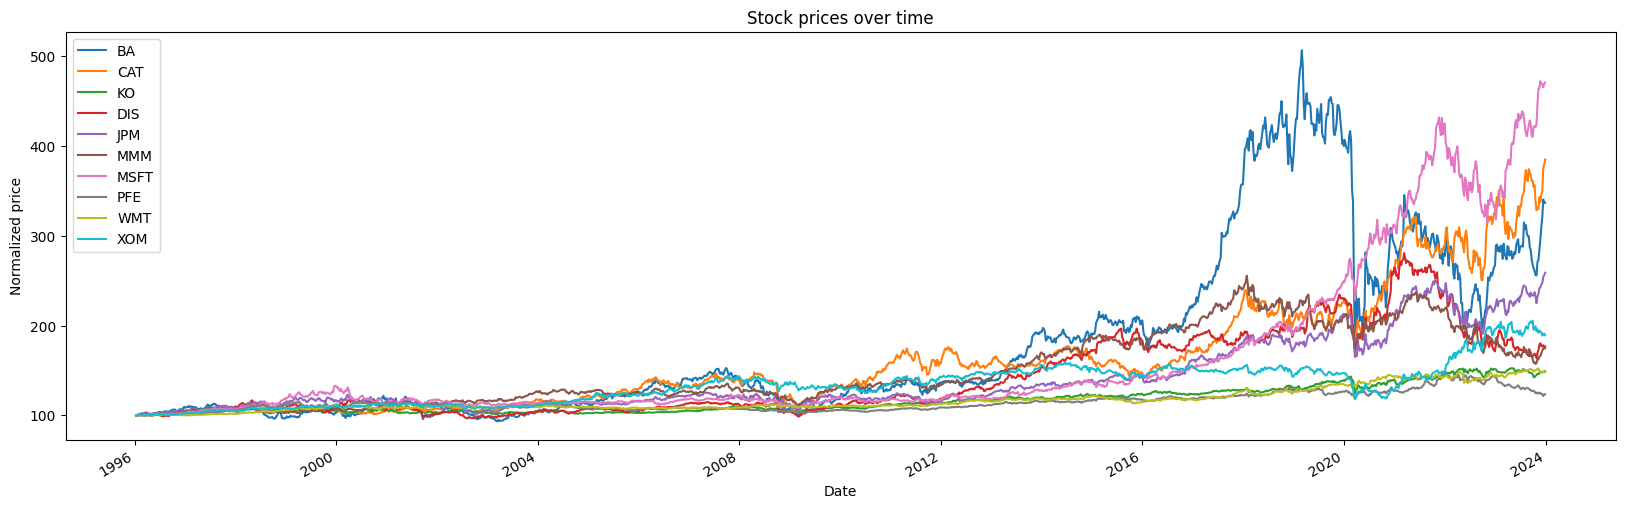

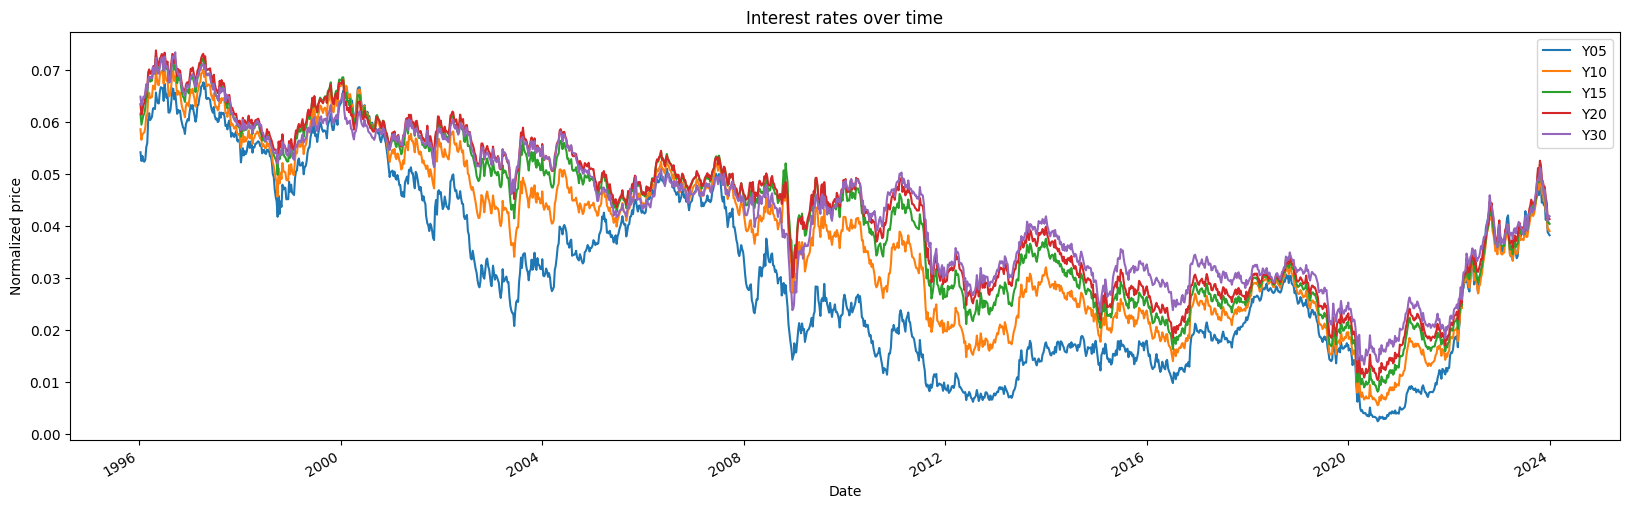

In [4]:
## a
marketDataDf = pd.read_csv('market_data.csv', sep=';', parse_dates=True, index_col='Date')
StockDF = marketDataDf.iloc[:,:10].copy()
RatesDF = marketDataDf.iloc[:,10:].copy()

InitialValue = StockDF.iloc[0]
normalizedDf = (100 - InitialValue) + StockDF
AllAssetsDf = pd.concat([normalizedDf,RatesDF], axis=1)

normalizedDf.plot(figsize=(20,6), title = 'Stock prices over time', ylabel='Normalized price');
RatesDF.plot(figsize=(20,6), title = 'Interest rates over time', ylabel='Normalized price');


In [5]:
## b
stockReturnDf = np.log(StockDF).diff()
stockReturnDf = stockReturnDf.dropna()

meanLogReturn = stockReturnDf.mean() * 250
volatilityLogReturns = stockReturnDf.std() * np.sqrt(250)
lowerPercentile = stockReturnDf.quantile(0.05)
upperPercentile = stockReturnDf.quantile(0.95)
minimum = stockReturnDf.min()
maximum = stockReturnDf.max()

TableDf = pd.DataFrame(columns=stockReturnDf.columns)
TableDf.loc['Mean Log Return'] = meanLogReturn
TableDf.loc['Volatility Log Returns'] = volatilityLogReturns
TableDf.loc['5th Percentile'] = lowerPercentile
TableDf.loc['95th Percentile'] = upperPercentile
TableDf.loc['Minimum'] = minimum
TableDf.loc['Maximum'] = maximum


TableDf

,BA,CAT,KO,DIS,JPM,MMM,MSFT,PFE,WMT,XOM
Mean Log Return,0.409276,0.637213,0.322325,0.307541,0.514701,0.344627,0.809750,0.334798,0.531562,0.423777
Volatility Log Returns,0.833350,0.719112,0.490862,0.619653,0.787666,0.513228,0.627998,0.561350,0.531959,0.531640
5th Percentile,-0.072979,-0.072514,-0.045274,-0.060455,-0.075834,-0.054422,-0.058759,-0.051922,-0.051592,-0.052012
95th Percentile,0.072263,0.076259,0.047819,0.064185,0.071254,0.051068,0.068038,0.058124,0.053755,0.053587
Minimum,-0.582992,-0.224978,-0.236452,-0.248513,-0.416844,-0.174427,-0.211151,-0.227099,-0.216747,-0.223982
Maximum,0.533614,0.269244,0.111502,0.163325,0.399379,0.160226,0.209799,0.133070,0.167702,0.154747


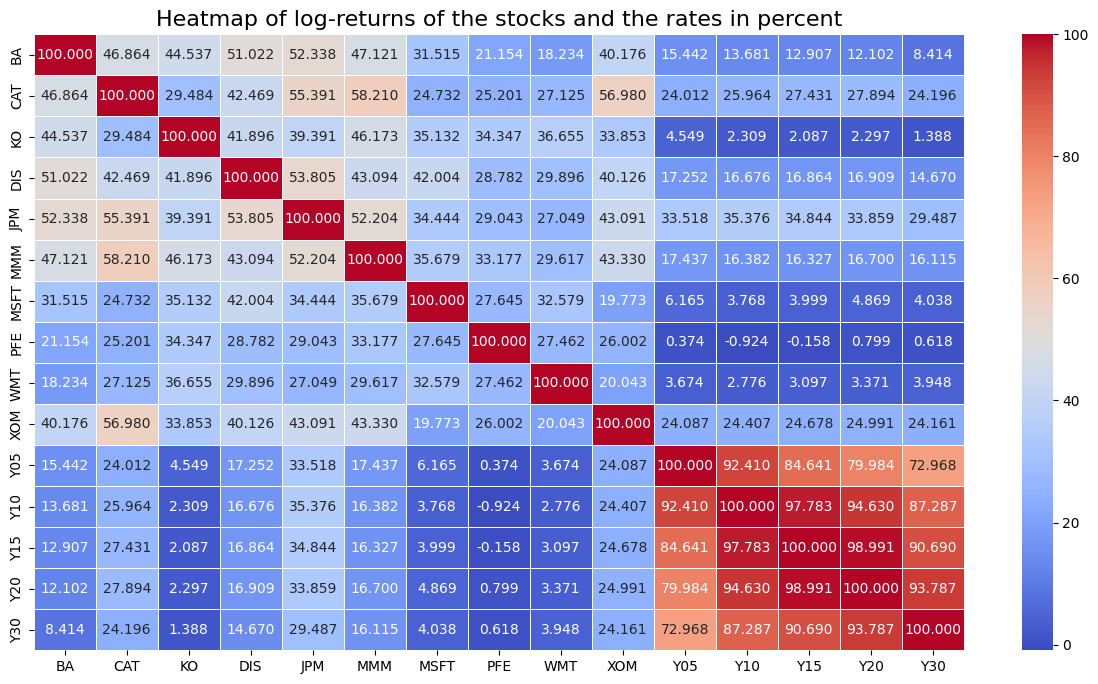

In [6]:
## c
AllAssetsLR= np.log(AllAssetsDf).diff()

corMat = AllAssetsLR.corr()*100
plt.figure(figsize=(15, 8))

sns.heatmap(corMat, annot=True, fmt=".3f",cmap='coolwarm', linewidths=0.5, linecolor='white');
plt.title('Heatmap of log-returns of the stocks and the rates in percent', fontsize=16);


## 2. VAR(1)-model 
Estimate a VAR(1)-model for the market. 
- a) Estimate the parameters (include them in the report) and check whether the model is stable or not 
(this check should also be detailed in the report). 
- b) Calculate the volatilities of the VAR-residuals and include them in the report. 
- c) Simulate 5000 scenarios with 480 weekly time steps for all assets and plot the price (or interest rate) 
percentiles (5%, 10%, 25%, 50%, 75%, 90%, 95%) for the stocks Caterpillar and Walmart and the 5- and 
30-year interest rates. 
A total of four plots. Also list these percentiles, for the time periods 240 and 
480, in two tables with the percentiles in the horizontal direction and the stocks and interest rates in 
the vertical direction.

In [7]:
# a)
oneVec = np.ones((AllAssetsLR.shape[0],1))
M = np.concatenate((oneVec, AllAssetsLR.values), axis=1)[1:-1,]
Y = AllAssetsLR.values[2:,:]

a = np.linalg.inv(M.T @ M) @ M.T @ Y

A1 = a[1:,:]
A0 = a[0,:]

e,v = np.linalg.eig(A1)

LargestAbsEigenvalue = max(abs(e))

stableTest = LargestAbsEigenvalue < 1
print(f'The largest absolute eigenvalue is: {LargestAbsEigenvalue}')
print(f'Is the model stable? : {stableTest} ')

The largest absolute eigenvalue is: 0.26346317555789145
Is the model stable? : True 


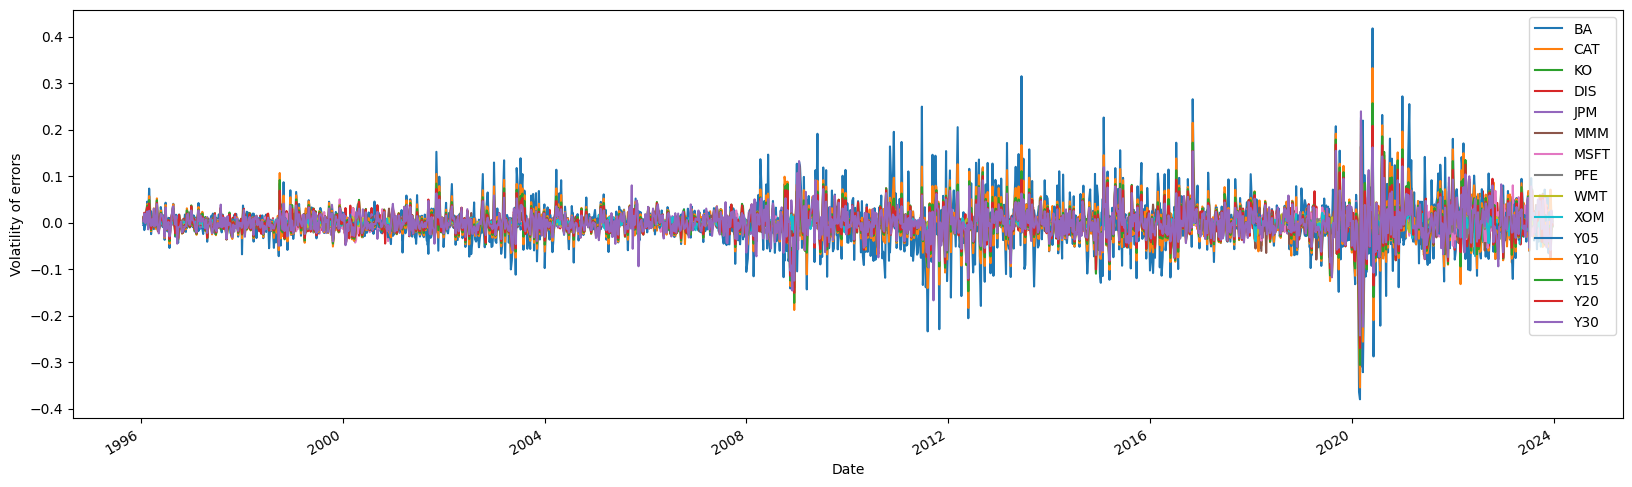

In [8]:
# b)

error = Y - M@a
errorVolatility = np.std(error, axis=0)


PlotVolatilityDF = pd.DataFrame(columns=AllAssetsLR.columns, data=error,index=AllAssetsDf.index[1:-1])
PlotVolatilityDF.plot(figsize=(20,6), ylabel='Volatility of errors');


In [9]:
VolDF = pd.DataFrame(columns=AllAssetsLR.columns)
VolDF.loc['Weekly Volatility'] = errorVolatility
VolDF

,BA,CAT,KO,DIS,JPM,MMM,MSFT,PFE,WMT,XOM,Y05,Y10,Y15,Y20,Y30
Weekly Volatility,0.027614,0.016692,0.006152,0.013737,0.013382,0.012084,0.012419,0.005727,0.005055,0.010451,0.06102,0.045657,0.038635,0.034968,0.033677


In [10]:
def VAR1Simulator(Y0, epsilon, A0, A1):
  simulations = epsilon.shape[0]
  numberOfStocks = epsilon.shape[1]
  timeSteps = epsilon.shape[2]

  # Function Stockprices(Z,X,r,sigma,dt) Should return S
  Y = np.zeros((simulations, numberOfStocks, timeSteps + 1 ))
  Y[0, :, 0] = Y0
  for i in range(simulations):
    for t in range(1, timeSteps + 1):
          Y[i, :, t] = A0 + A1 @ Y[i, :, t-1] + epsilon[i, :, t-1]
  return Y

In [11]:
# c)

simulations = 5000
weeklyTimestep = 480
numberOfStocks = len(AllAssetsLR.columns)

covMat = AllAssetsLR.cov()

choleskyMatrix = np.linalg.cholesky(covMat)

# Generate random number cube where depth is simulations, height is stocks, width is time steps
Z = np.random.standard_normal((simulations, numberOfStocks,  weeklyTimestep))
X = choleskyMatrix@Z

Y0 = AllAssetsLR.iloc[-1:].values

simulatedLR = VAR1Simulator(Y0, X, A0, A1)


In [12]:
sumLogReturns = np.cumsum(simulatedLR, axis=2)
initialPrice = AllAssetsDf.iloc[-1,].values
flattenedInitialPrice = initialPrice.flatten()
initialPriceMatrix = np.tile(flattenedInitialPrice, (5000, 480, 1)).transpose(0, 2, 1)
simulatedPrices = initialPriceMatrix*np.exp(sumLogReturns[:, :, 1:])

quantileValues = [0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]

catepillarPercentile = np.zeros((weeklyTimestep, len(quantileValues)))
walmartPercentile = np.zeros((weeklyTimestep, len(quantileValues)))
fiveYearPercentile = np.zeros((weeklyTimestep, len(quantileValues)))
thirtyYearPercentile = np.zeros((weeklyTimestep, len(quantileValues)))

for i in range(0,weeklyTimestep):
    for j in range(0, len(quantileValues)):
        catepillarPercentile[i, j] = np.quantile(simulatedPrices[:, 1, i], quantileValues[j])
        walmartPercentile[i, j] = np.quantile(simulatedPrices[:, 8, i], quantileValues[j])
        fiveYearPercentile[i, j] = np.quantile(simulatedPrices[:, 10, i], quantileValues[j])
        thirtyYearPercentile[i, j] = np.quantile(simulatedPrices[:, 14, i], quantileValues[j])


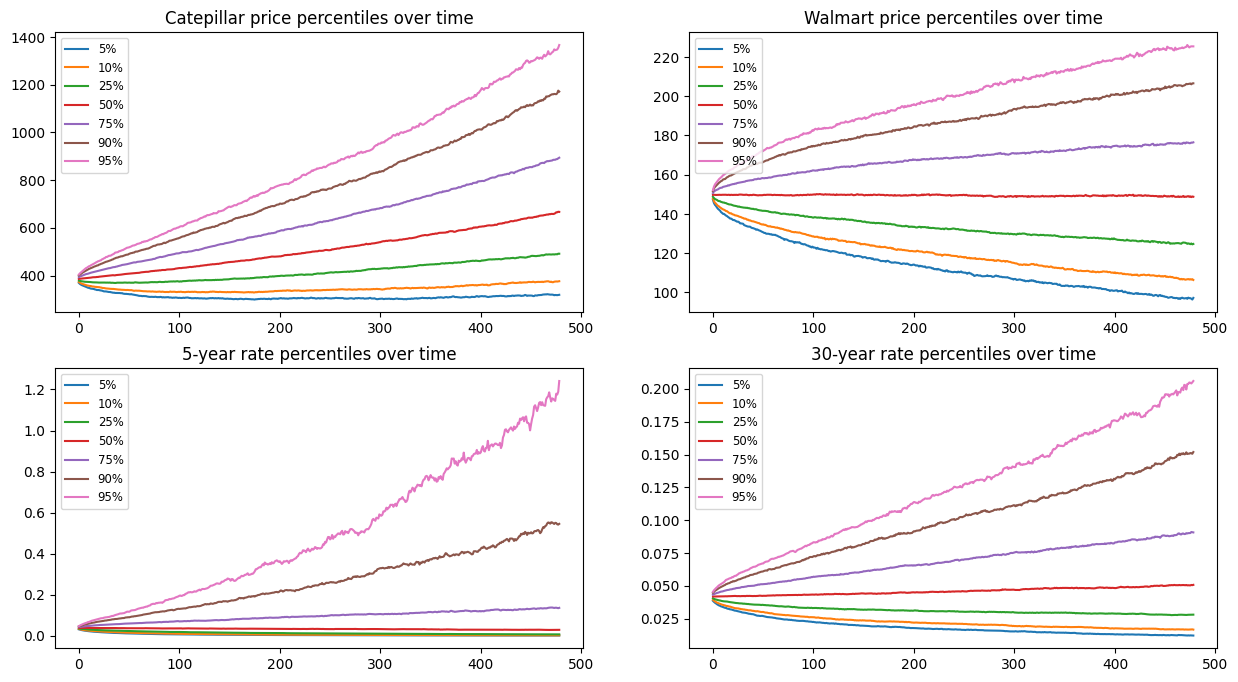

In [13]:
percentiles = ['5%', '10%', '25%', '50%', '75%', '90%', '95%']
fig, ax = plt.subplots(2, 2, figsize=(15, 8))

for i, label in enumerate(percentiles):
    ax[0, 0].plot(catepillarPercentile[1:, i], label=label)

ax[0, 0].set_title('Catepillar price percentiles over time')
ax[0, 0].legend(fontsize = 'small')

for i, label in enumerate(percentiles):
    ax[0, 1].plot(walmartPercentile[1:, i], label=label)

ax[0, 1].set_title('Walmart price percentiles over time')
ax[0, 1].legend(fontsize = 'small')

for i, label in enumerate(percentiles):
    ax[1, 0].plot(fiveYearPercentile[1:, i], label=label)

ax[1, 0].set_title('5-year rate percentiles over time')
ax[1, 0].legend(fontsize = 'small')

for i, label in enumerate(percentiles):
    ax[1, 1].plot(thirtyYearPercentile[1:, i], label=label)

ax[1, 1].set_title('30-year rate percentiles over time')
ax[1, 1].legend(fontsize = 'small')

plt.show()

In [14]:
fullTableDf = pd.DataFrame(columns=percentiles)
fullTableDf.loc['Catepillar'] = catepillarPercentile[479,:]
fullTableDf.loc['Walmart'] = walmartPercentile[479,:]
fullTableDf.loc['5-year rate'] = fiveYearPercentile[479,:]
fullTableDf.loc['30-year rate'] = thirtyYearPercentile[479,:]

title = "                           Price and Rate Percentiles for 480 weeks"

print(title)
fullTableDf

                           Price and Rate Percentiles for 480 weeks


,5%,10%,25%,50%,75%,90%,95%
Catepillar,318.989082,376.016520,491.336968,666.767803,893.953762,1171.292867,1366.642553
Walmart,97.205030,106.364509,124.706190,148.780430,176.503897,206.589524,225.422456
5-year rate,0.000762,0.001689,0.006475,0.028596,0.135717,0.545118,1.241350
30-year rate,0.012209,0.016735,0.028115,0.050777,0.090717,0.151894,0.205957


In [15]:
halfTableDf = pd.DataFrame(columns=percentiles)
halfTableDf.loc['Catepillar'] = catepillarPercentile[239,:]
halfTableDf.loc['Walmart'] = walmartPercentile[239,:]
halfTableDf.loc['5-year rate'] = fiveYearPercentile[239,:]
halfTableDf.loc['30-year rate'] = thirtyYearPercentile[239,:]

title = "                           Price and Rate Percentiles for 240 weeks"

print(title)
halfTableDf

                           Price and Rate Percentiles for 240 weeks


,5%,10%,25%,50%,75%,90%,95%
Catepillar,305.074542,337.356643,408.778811,502.098835,622.922047,752.345961,848.079065
Walmart,110.348327,118.653354,132.461102,149.422394,168.569600,187.130465,200.456396
5-year rate,0.002627,0.004558,0.011504,0.033266,0.094915,0.245017,0.427299
30-year rate,0.016862,0.021222,0.030759,0.045691,0.068961,0.100627,0.123827


## 3. Historical simulation 
Use basic historical simulation to simulate 5000 scenarios with 480 weekly time steps for all assets and plot 
the price (or interest rate) percentiles (5%, 10%, 25%, 50%, 75%, 90%, 95%) for the stocks Caterpillar and 
Walmart and the 5- and 30-year interest rates. A total of four plots. Also list these percentiles, for the time 
periods 240 and 480, in two tables with the percentiles in the horizontal direction and the stocks and interest 
rates in the vertical direction. Plot the percentiles (as dotted lines) in the same plot as the VAR(1)-percentiles. 

## 4. VAR(1)-DCC-model 
Estimate a VAR(1)-DCC-model for the market 
- a) Plot the ACF, for lags 1 to 50, for the (weekly) residuals and square residuals of the VAR-model, for 
Caterpillar and the 5-year interest rate.  
- b) Estimate the DCC-model and include the DCC-parameters in the report: delta, gamma, the R-matrix 
and the GARCH(1,1)-parameters as a 15*3-matrix. 
- c) Do 2.c) again and plot the price (or interest rate) percentiles (as dashed lines) in the same plot as the 
VAR(1)- and HS-percentiles 


Discussion: What does a) tell you?  

## 5. Explore the data 
You can do this part of the assignment in Excel (in that case submit also the Excel file).  
- a) Plot the average, over the five years of data, of the mean population for each age for both men and 
women in the same figure. 
- b) Plot the average, over the five years of data, of the number of deaths for each age for both men and 
women in the same figure.   


Discussion: What do these plots tell you? 

In [21]:
menDeathsDF = pd.read_excel('deathsMen.xlsx').dropna()
womenDeathsDF = pd.read_excel('deathsWomen.xlsx').dropna()
menPopulationDF = pd.read_excel('populationMen.xlsx').dropna()
womenPopulationDF = pd.read_excel('populationWomen.xlsx').dropna()

menDeathsDF.set_index('Döda efter ålder, kön och år', inplace = True)
menDeathsDF.drop(columns='Unnamed: 1', inplace = True)
womenDeathsDF.set_index('Döda efter ålder, kön och år', inplace = True)
womenDeathsDF.drop(columns='Unnamed: 1', inplace = True)

menPopulationDF.set_index('Medelfolkmängd (efter födelseår) efter ålder, kön och år', inplace = True)
menPopulationDF.drop(columns='Unnamed: 1', inplace = True)
womenPopulationDF.set_index('Medelfolkmängd (efter födelseår) efter ålder, kön och år', inplace = True)
womenPopulationDF.drop(columns='Unnamed: 1', inplace = True)



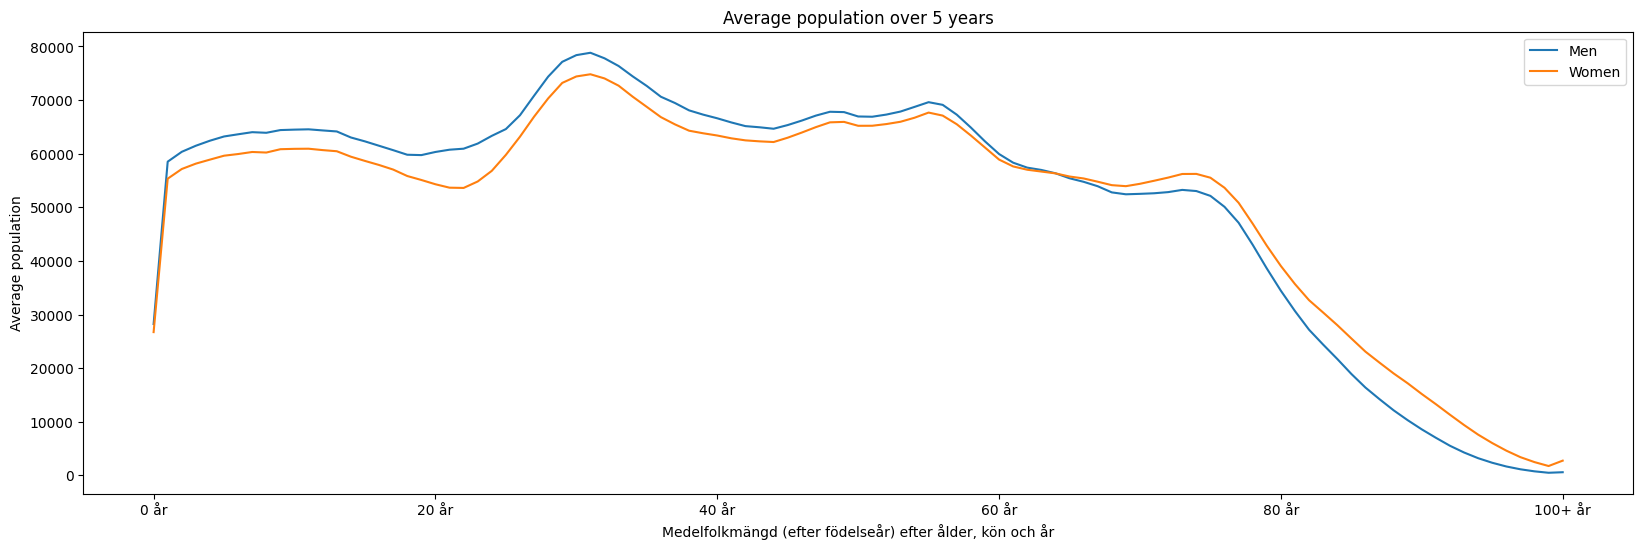

In [22]:
np.mean(menPopulationDF, axis=1).plot(figsize=(20,6),title='Average population over 5 years', ylabel='Average population', label='Men');
np.mean(womenPopulationDF, axis=1).plot(figsize=(20,6), ylabel='Average population', label='Women');
plt.legend();

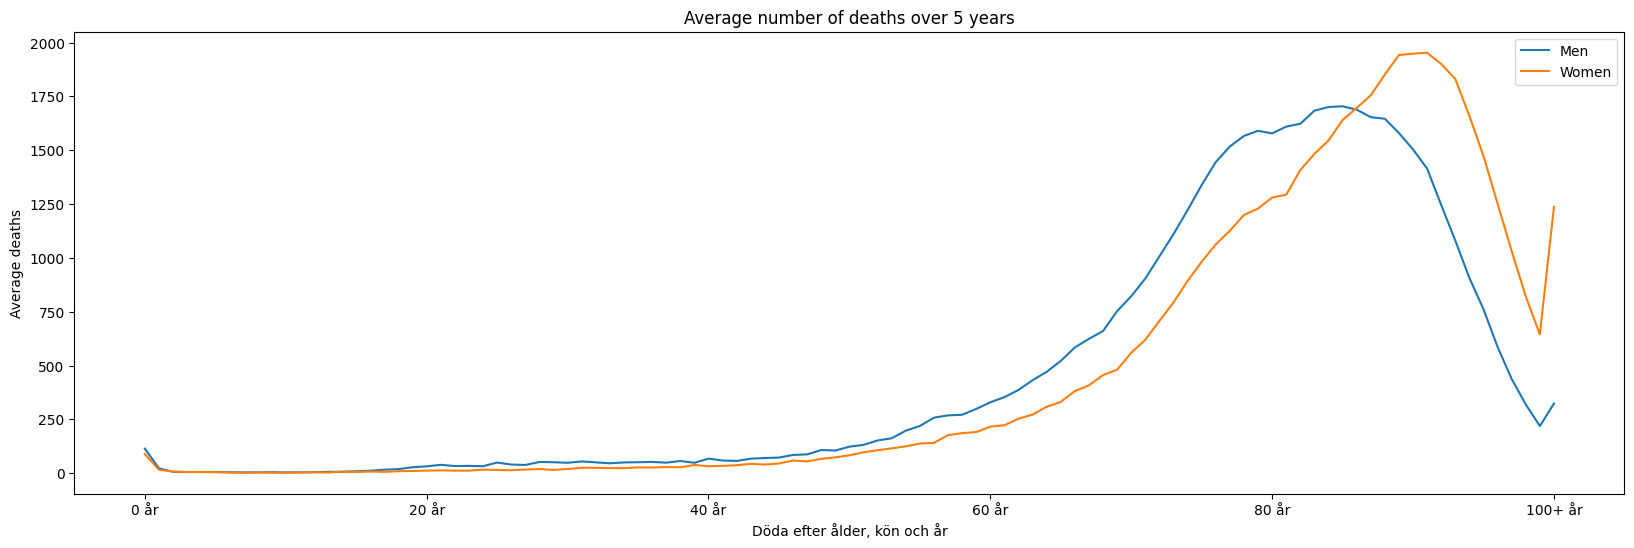

In [23]:
averageDeathsMen = np.mean(menDeathsDF, axis=1)
averageDeathsWomen = np.mean(womenDeathsDF, axis=1)
averageDeathsMen.plot(figsize=(20,6), title='Average number of deaths over 5 years', ylabel='Average deaths', label='Men');
averageDeathsWomen.plot(figsize=(20,6), ylabel='Average deaths', label='Women');
plt.legend();

## 6. Mortality estimation 
This task is also suitable for Excel, where you can use Solver to find the Makeham parameters. 
- a) Estimate the force of mortality for men and women separately using the SCB-data and plot these 
estimates in the same figure. Do this for ages 20 – 99 and use data for all five years for a more stable 
estimate. 
- b) Fit Makeham functions using only force of mortality estimates for ages 20 – 90 from above. Then plot 
the estimated forces of mortality, for ages 20 – 99, together with the Makeham functions in the same 
figure (both men and women). Include the parameters in the report. 
- c) Plot the survival functions for men and women, for ages 0 – 105, in the same figure (but not the same 
as in b).  
- d) Calculate life expectancy for both men and women, according to the lifetime distributions given by the 
Makeham functions. 

In [24]:
# a)
DMen = menDeathsDF.sum(axis=1)
DWomen = womenDeathsDF.sum(axis=1)

NMen = menPopulationDF.sum(axis=1)
NWomen = womenPopulationDF.sum(axis=1)

muMen = DMen/NMen
muWomen = DWomen/NWomen

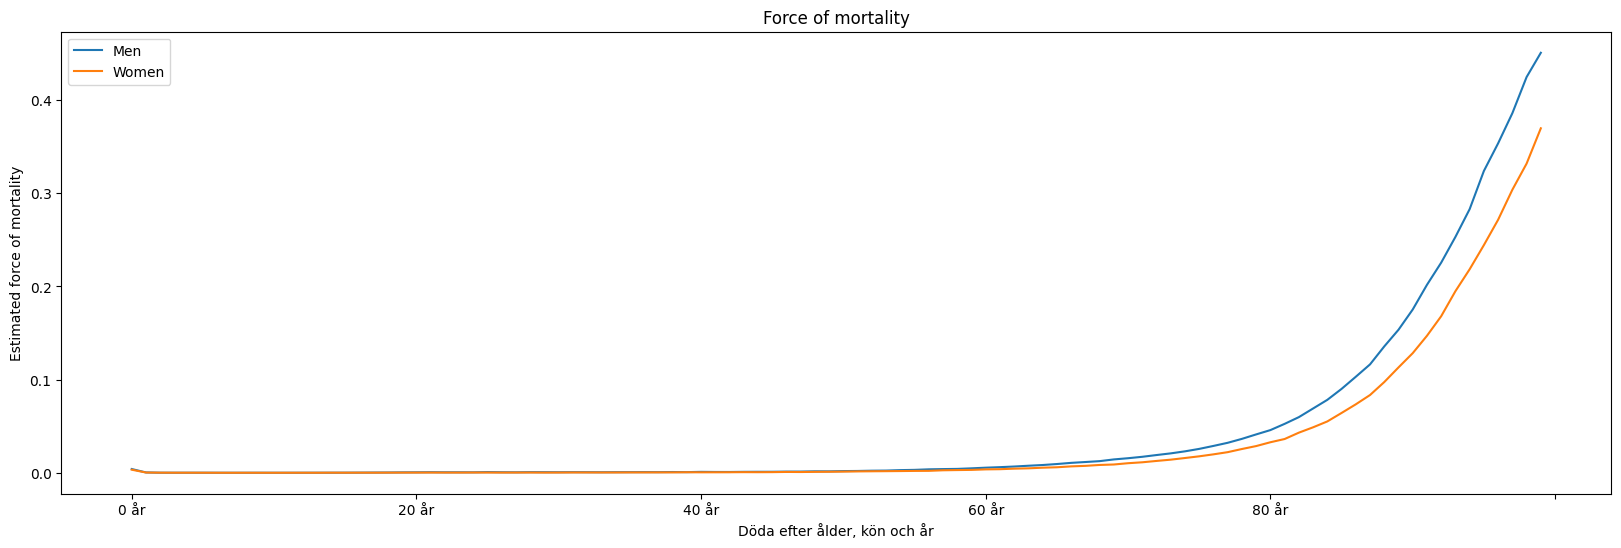

In [25]:
muMen.iloc[:-1].plot(figsize=(20,6), title='Force of mortality', ylabel='Estimated force of mortality', label='Men');
muWomen.iloc[:-1].plot(figsize=(20,6), label='Women');
plt.legend();

In [26]:
def gammaFunction(gamma, mu, ages):

    f1 = np.sum(np.exp(gamma * ages))
    f2 = np.sum(np.exp(2 * gamma * ages))
    m = np.sum(mu)
    g = np.sum(mu * np.exp(gamma * ages))
    
    beta = (m * f1 - ages[-1] * g) / (f1**2 - ages[-1] * f2)
    alpha = (m * f2 - g * f1) / (ages[-1] * f2 - f1**2)
    
    eq = np.sum(alpha + beta * np.exp(gamma * ages) - mu)
    
    return eq

def alphaBetaFunction(gamma, mu, ages):

    f1 = np.sum(np.exp(gamma * ages))
    f2 = np.sum(np.exp(2 * gamma * ages))
    m = np.sum(mu)
    g = np.sum(mu * np.exp(gamma * ages))
    alpha = (m * f2 - g * f1) / (ages[-1] * f2 - f1**2)
    beta = (m * f1 - ages[-1] * g) / (f1**2 - ages[-1] * f2)

    return alpha, beta

def makehamFunction(alpha, beta, gamma, x):

    makeham = alpha+beta*np.exp(gamma*x)
    
    return makeham

In [27]:
gammaInitialGuess = 0.1
numberOfYears = np.arange(20, 90)
startYear = 20
endYear = 90
endYearPlot = 99

numberOfYearsPlot = np.arange(20, 99)

gammaMen = fsolve(lambda gamma:gammaFunction(gamma, muMen.iloc[startYear:endYear].values, numberOfYears), gammaInitialGuess)
alphaMen,betaMen = alphaBetaFunction(gammaMen, muMen.iloc[startYear:endYear].values, numberOfYears)
makehamMen = makehamFunction(alphaMen, betaMen, gammaMen, numberOfYearsPlot)

gammaWomen = fsolve(lambda gamma:gammaFunction(gamma, muWomen.iloc[startYear:endYear].values, numberOfYears), gammaInitialGuess)
alphaWomen,betaWomen = alphaBetaFunction(gammaWomen, muWomen.iloc[startYear:endYear].values, numberOfYears)
makehamWomen = makehamFunction(alphaWomen, betaWomen, gammaWomen, numberOfYearsPlot)


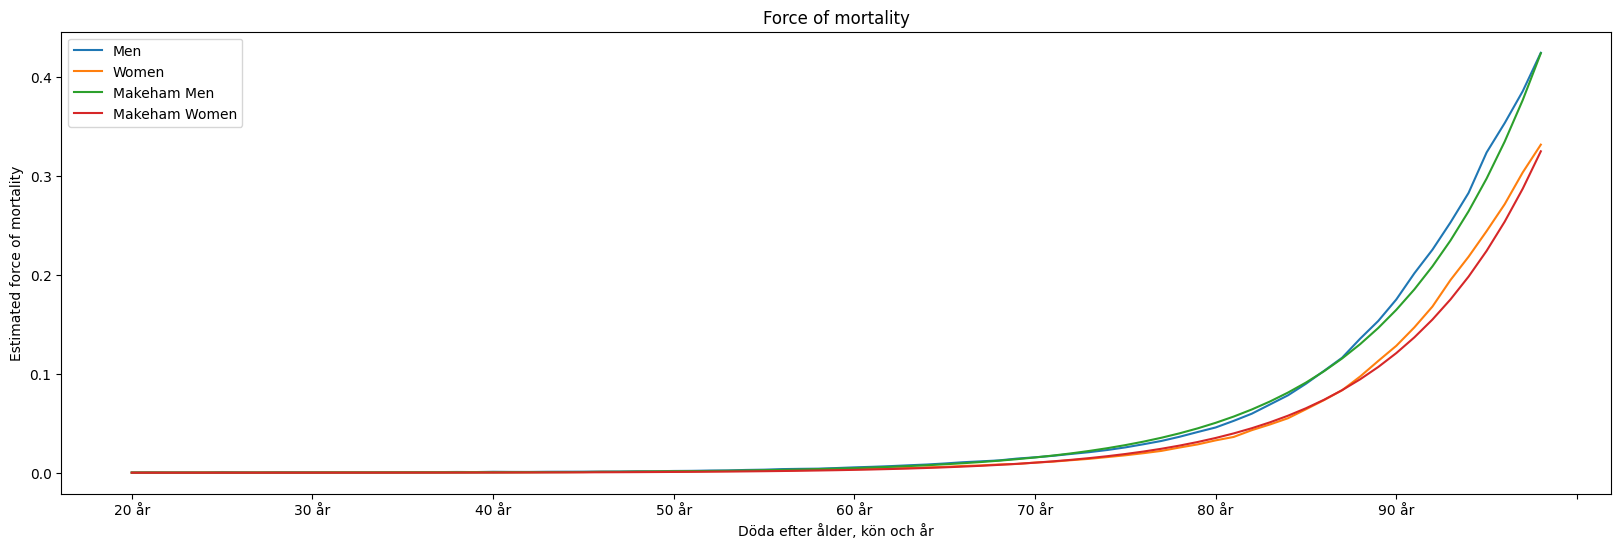

In [28]:


muMen.iloc[startYear:endYearPlot].plot(figsize=(20,6), title='Force of mortality', ylabel='Estimated force of mortality', label='Men');
muWomen[startYear:endYearPlot].plot(figsize=(20,6), label='Women');
plt.plot(makehamMen, label = "Makeham Men")
plt.plot(makehamWomen, label = "Makeham Women")
plt.legend();

In [29]:
def survivalFunction(alpha, beta, gamma, x):
    l = np.exp( -alpha*x - (beta/gamma)*(np.exp(gamma*x)-1))
    return l


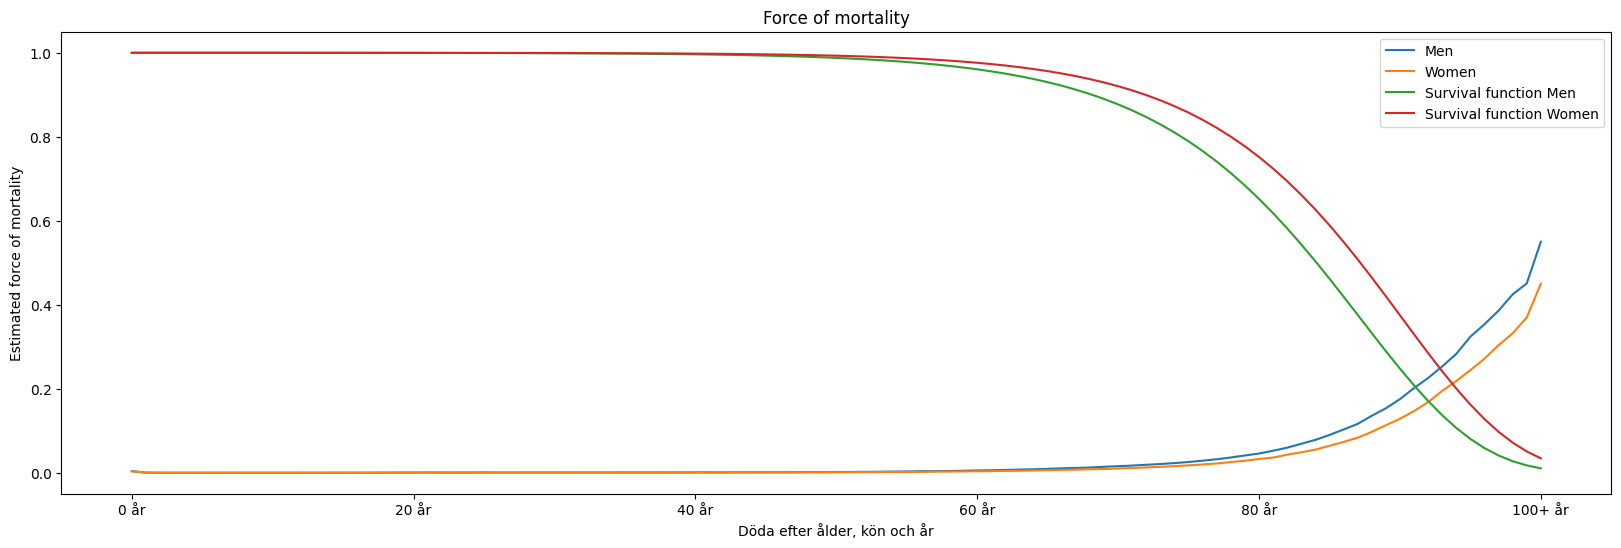

In [30]:
allYears = np.arange(0,len(muMen))
survivalMen = survivalFunction(alphaMen, betaMen, gammaMen, allYears)
survivalWomen = survivalFunction(alphaWomen, betaWomen, gammaWomen, allYears)

muMen.plot(figsize=(20,6), title='Force of mortality', ylabel='Estimated force of mortality', label='Men');
muWomen.plot(figsize=(20,6), label='Women');
plt.plot(survivalMen, label = 'Survival function Men')
plt.plot(survivalWomen, label = 'Survival function Women')
plt.legend();

In [31]:
lifeExpectancyMen = np.sum(survivalMen)
lifeExpectancyWomen = np.sum(survivalWomen)


print('Life expectancy for men:', lifeExpectancyMen)
print('Life expectancy for women:', lifeExpectancyWomen)

Life expectancy for men: 82.79646354919109
Life expectancy for women: 85.93871896460792


## 7. 1st order payout and reserve 
Calculate the guaranteed payout amount and project the 1st order reserve for the policy.  
- a) Determine the yearly payout amount, b.  
- b) Plot the evolution of the reserve 30 years into the future.  
- c) Include a table with the value of the reserve for every 5 years.  

In [70]:
def expectedPremiumSum(alpha, beta, gamma, x, t, deltaG):

    lt = survivalFunction(alpha, beta, gamma, (x+(t/12)))
    lx = survivalFunction(alpha, beta, gamma, (x))
    PVsum = np.sum(lt/lx*np.exp(-deltaG*(t/12)))

    return PVsum

def expectedPayoutSum(alpha, beta, gamma, x, t, deltaG):

    lt = survivalFunction(alpha, beta, gamma, (x+(t/12)))
    lx = survivalFunction(alpha, beta, gamma, (x))
    PVsum = np.sum(lt/lx*np.exp(-deltaG*(t/12)))

    return PVsum

def riskPremium(alpha, beta, gamma, x, t, G0):

    lt = survivalFunction(alpha, beta, gamma, (x+(t/12)))
    lx = survivalFunction(alpha, beta, gamma, (x))
    qm = 1 - lt/lx
    r = qm/(1-qm)*G0

    return r

def reserveFunction(G0, P, b, alpha, beta, gamma, x, t, u, deltaG):

    if(t<12*(u+1)):
        G = G0*deltaG - riskPremium(alpha, beta, gamma, x, t, G0) + P/12*expectedPremiumSum(alpha, beta, gamma, x, t, deltaG)
    else:
         G = G0*deltaG - riskPremium(alpha, beta, gamma, x, t, G0) - b/12*expectedPayoutSum(alpha, beta, gamma, x, t, deltaG)
    return G


In [71]:

# a)
deltaG = 0.02
x = 60
z = 65
s = 120-z
u = z-x
t = 1
T = 12*(u+2)
b = 0
P = 120000
G0 = 2000000
for i in range(t, T):
    if(i<(12*(u+1))):
        G = 12*(reserveFunction(G0, P, b, alphaWomen, betaWomen, gammaWomen, x, t, u, deltaG) + P/12*expectedPremiumSum(alphaWomen, betaWomen, gammaWomen, x, t, deltaG))
    else:
        b = 12*G/expectedPayoutSum(alphaWomen, betaWomen, gammaWomen, x, i, deltaG)


In [72]:
def qx(alpha, beta, gamma, x, t):

    lt = survivalFunction(alpha, beta, gamma, (x+(t/12)))
    lx = survivalFunction(alpha, beta, gamma, (x+((t-1)/12)))
    qm = 1 - lt/lx

    return qm

In [73]:
def deadPopulation(pop_pp, pop_po, alpha, beta, gamma, x, t):
    
    t_pp_de = pop_pp*qx(alpha, beta, gamma, x, t)
    t_po_de = pop_po*qx(alpha, beta, gamma, x, t)

    return t_pp_de, t_po_de


In [74]:
def transferPopulation(pop_pp, t_pp_de, s):

    sm = 1-(1-s)**(1/12)
    t_pp_tr = (pop_pp-t_pp_de)*sm
    
    return t_pp_tr

In [75]:
def payoutTransfer(pop_pp, t_pp_de, t_pp_tr, t, u):

    if(t!=u):
        return 0
    
    return(pop_pp-t_pp_de-t_pp_tr)


In [76]:
# b)

t = 1
T = 12*(u+s)
st = 0
# Initializing populations
pop_pp = 1
pop_po = 0
pop_de = 0
pop_tr = 0

cashFlow = np.zeros((T-1))

# Updating populations
for i in range(t, T):

    t_pp_de, t_po_de = deadPopulation(pop_pp, pop_po, alphaWomen, betaWomen, gammaWomen, x, t)
    t_pp_tr = transferPopulation(pop_pp, t_pp_de, st)
    t_pp_po = payoutTransfer(pop_pp, t_pp_de, t_pp_tr, t, u)

    pop_pp = pop_pp - t_pp_de - t_pp_tr - t_pp_po
    pop_po = pop_po - t_po_de - t_pp_po
    pop_de = pop_de + t_pp_de + t_po_de
    pop_tr = pop_tr + t_pp_tr

    cashFlow[i-1] = pop_po*b/12 + t_pp_tr*reserveFunction(G0, P, b, alphaWomen, betaWomen, gammaWomen, x, t-1, u, deltaG) - pop_pp*P/12

C:\Users\emill\AppData\Local\Temp\ipykernel_2232\311053938.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cashFlow[i-1] = pop_po*b/12 + t_pp_tr*reserveFunction(G0, P, b, alphaWomen, betaWomen, gammaWomen, x, t-1, u, deltaG) - pop_pp*P/12
